In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from scipy.stats import poisson
from tqdm.notebook import tqdm
from time import time
%matplotlib inline

from tqdm import tqdm
import tensorflow as tf
import random

In [2]:
def drift(x,kappa,theta):
    
    return kappa*(theta-x)


def diff(x,sigma):
    
    return sigma
    

In [3]:
def normal_generator(mu_jump, sigma_jump, num_events):
    return np.random.normal(mu_jump, sigma_jump, num_events)

def compound_poisson_process(rate, dt, mu_jump, sigma_jump):
    num_events = np.random.poisson(rate*dt, size = 1)
    jumps = normal_generator(mu_jump = mu_jump, sigma_jump = sigma_jump, num_events = num_events)
    
    jump = jumps.sum()

    if len(jumps) == 0:
        jump = 0
        
    return jump

In [4]:
def ctmc(R_0, Q, dt, T):
    
    R_0 = int(R_0)
    T = float(T)
    
    #T = 1.  # Total time.
    n = int(T / dt)  # Number of time steps.
    t = np.linspace(0., T, n)
    
    if len(t) == 0.0:
        return [R_0], [T]
        
    Q_rates = Q[~np.eye(Q.shape[0],dtype=bool)].reshape(Q.shape[0],-1)
    
    states = [R_0]
    event_time = t[0]
    times = [t[0]]
    #n = 0 
    
    lambdas = [sum(Q_rates[i]) for i in range(len(Q_rates))]
    #lambdas_sum = np.cumsum(lambdas)
    
    while event_time <= T:
        
        R = states[len(states) - 1]
        l_i = lambdas[R]
        l_sum = np.cumsum(Q_rates[R])

        rate = sum(Q_rates[R])
       
        holding_time = np.random.exponential(scale = 1 / rate)

        event_time = event_time + holding_time
        if event_time <= T:
            times.append(event_time)

            u = np.random.uniform() 

            j = np.min(np.where(u <= (l_sum / l_i))[0])  ### Check! 

            if j >= R: 
                state_new = j + 1
            else:
                state_new = j 

            #print(f'state{ state_new}')

            states.append(state_new)

    return states, times        
    

In [5]:
def ou_jump_gen_sim_stopping(kappa_vec, theta_vec, sigma_vec, ksi, theta_vol, omega, 
                             mu_jump, sigma_jump, rate, dt, x_0, R_0, y_0, Q, n_sim, stopping, T, PD_flag):
    
    R_0 = int(R_0)
    T = float(T)
    #T = 1.  # Total time.
    n = int(T / dt)  # Number of time steps.
    t = np.linspace(0., T, n)  # Vector of times.
    x = np.zeros(n)
    y = np.zeros(n)
    
    
    if len(x) == 0.0:
        ruin_prob = 0.0 if x_0 <= stopping else 1.0 
        return [x_0], [y_0],[R_0], [T], ruin_prob
    
    x[0] = x_0
    y[0] = y_0
    x_origin = x
    y_origin = y
    x_list = list()
    y_list = list()
    ruin_count = 0
    
    regime_states, regime_times = ctmc(R_0, Q, dt, T)
    
    regime_times.append(T)
    
    for j in range(n_sim):
        
        if n-1 == 0:
            stopping_factor = 0.0 if ((isinstance(stopping, float)) and (x[0] <= stopping)) else 1.0
        else:
        
            for i in range(n - 1):

                # For regime-switch
                time_interval_index = np.min(np.where(regime_times > t[i])[0])  ### Check!
                state = regime_states[time_interval_index - 1]

                kappa = kappa_vec[state]
                theta = theta_vec[state]
                sigma = sigma_vec[state]

                stopping_factor = 0.0 if ((isinstance(stopping, float)) and (x[i] <= stopping)) else 1.0
                
                if PD_flag and (np.array([kappa, theta, sigma]) == 0.0).all():
                    
                    stopping_factor = 0.0
                    x[i] = stopping

                jump = compound_poisson_process(rate, dt, mu_jump, sigma_jump)

                y[i+1] = y[i] + drift(y[i], kappa = theta_vol, theta = omega)*dt + diff(y[i], sigma = ksi)*np.sqrt(y[i])*np.sqrt(dt)*np.random.randn()

                x[i + 1] = x[i] + stopping_factor*(drift(x[i], kappa=kappa, theta=theta)*dt + diff(x[i], sigma = np.sqrt(y[i+1]))*np.sqrt(dt)*np.random.randn() \
                                + jump)
            

        #plt.plot(t, x.copy(), lw=1)
        
        x_list.append(x.copy())
        y_list.append(y.copy())
        
        x = x_origin
        y = y_origin
        
        if stopping_factor == 0.0:
                ruin_count += 1
        
        stopping_factor = 1.0
        
    ruin_prob = ruin_count / n_sim    
    #plt.show()
    
    return x_list, y_list, regime_states, regime_times, ruin_prob

   

In [8]:
# Q = np.array([[-0.5, 0.3, 0.2], 
#     [0.3, -0.6, 0.3],   
#     [0.1,0.1,-0.2]])
# kappa_vec = np.array([0.3,0.2,0.2])
# theta_vec = np.array([0.5, 0.8, 0.2])
# sigma_vec = np.array([0.5, 0.3, 0.6])
# ksi = 0.5
# theta_vol = 0.7
# omega = 1.0
# x_0 = 0.5
# dt = 0.0001
# n_sim = 1000
# Q = Q
# R_0 = 2
# y_0 = 1.0
# mu_jump = 0.0
# sigma_jump = 0.5
# rate = 1.0
# stopping = 0.0

# ou_list, vol_list, states, times, prob = ou_jump_gen_sim_stopping(kappa_vec, theta_vec, sigma_vec, ksi, theta_vol, omega, 
#                                                         mu_jump, sigma_jump, rate, dt, x_0, R_0, y_0, n_sim, stopping)

# print(prob)

In [ ]:
from tqdm import tqdm

In [ ]:
# prob_ex_list = []

# for start in tqdm(np.linspace(0.0, 5.0, 51)):

#     Q = np.array([[-0.5, 0.3, 0.2], 
#         [0.3, -0.6, 0.3],   
#         [0.1,0.1,-0.2]])
#     kappa_vec = np.array([0.3,0.2,0.2])
#     theta_vec = np.array([0.5, 0.8, 0.2])
#     sigma_vec = np.array([0.5, 0.3, 0.6])
#     ksi = 0.5
#     theta_vol = 0.7
#     omega = 1.0
#     x_0 = start
#     dt = 0.0001
#     n_sim = 300
#     Q = Q
#     R_0 = 2
#     y_0 = 1.0
#     mu_jump = 0.0
#     sigma_jump = 0.5
#     rate = 1.0
#     stopping = 0.0

#     ou_list, vol_list, states, times, prob = ou_jump_gen_sim_stopping(kappa_vec, theta_vec, sigma_vec, ksi, theta_vol, 
#                                                                       omega, mu_jump, sigma_jump, rate, dt, x_0, R_0,
#                                                                       y_0, Q, n_sim, stopping)

#     print(f'For x0 {start} PD is {prob}')
    
#     prob_ex_list.append(prob)


In [78]:
np.save('prob_ex_list_gen.npy', np.array(prob_ex_list))

In [79]:
prob_ex_trial = np.load('prob_ex_list_gen.npy') # load

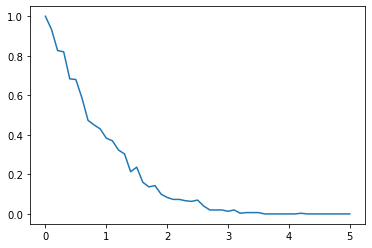

In [81]:
plt.plot(np.linspace(0.0, 5.0, 51), prob_ex_list)
plt.show()

# Neural network ruin probability estimations

In [10]:
def g_func(path, stopping):
    
    #T = 1.  # Total time.
    #n = int(T / dt)  # Number of time steps.
    #t = np.linspace(0., T, n)
    
    #path, ruin = ou_sim_2(kappa, theta, sigma, dt, x_0, 1, stopping)
    
    #g = tf.constant(1.0) if (tf.math.reduce_any(path <= 0)) else tf.constant(0.0)
    g = tf.constant(1.0) if (np.any(np.array(path) <= 0)) else tf.constant(0.0)
    return g
    

In [11]:
from tqdm.notebook import tqdm

In [12]:
# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
Q = np.array([[-0.5, 0.3, 0.2], 
    [0.3, -0.6, 0.3],   
    [0.5, 0.2, -0.7]])
kappa_vec = np.array([0.3,0.2,0.1])
theta_vec = np.array([0.8, 0.5, 0.6])
sigma_vec = np.array([0.3, 0.5, 0.4])
#R_0 = 0

ksi = 0.07
theta_vol = 0.05
omega = 0.1
#y_0 = 2.0

mu_jump = 0.0
sigma_jump = 0.5
rate = 1.0
stopping = 0.0

dt = 0.0001

# Set boundary
xmin = -10.0
xmax = 50.0
ymin = 0.0
ymax = 50.0

# Lower bounds
lb_x = tf.constant([xmin], dtype=DTYPE)
lb_y = tf.constant([ymin], dtype=DTYPE)
# Upper bounds
ub_x = tf.constant([xmax], dtype=DTYPE)
ub_y = tf.constant([ymax], dtype=DTYPE)


# Set random seed for reproducible results
tf.random.set_seed(100)

N_sim = 60000

## Draw random initial positions and simulate 
X_0_data = tf.random.uniform((N_sim,1), lb_x, ub_x, dtype=DTYPE)
t_data = tf.random.uniform((N_sim,1), 0.0, 1.0, dtype = DTYPE)
R_data = tf.cast(tf.reshape(tf.random.categorical(tf.math.log([[1/3,1/3,1/3]]), N_sim), (N_sim,1)),tf.float32)
Y_0_data = tf.random.uniform((N_sim,1), lb_y, ub_y, dtype=DTYPE)

## Concatenate all parameters that will constitute model input
process_data = tf.concat([X_0_data, t_data, R_data, Y_0_data], axis=1)

## Simulate path for each initial position (only one path)

path_data_list = []
for i in tqdm(range(len(X_0_data))):
    
    path_data, vol_list, states, times, prob = ou_jump_gen_sim_stopping(kappa_vec = kappa_vec, theta_vec = theta_vec, 
                                                                      sigma_vec = sigma_vec, ksi = ksi, theta_vol = theta_vol, 
                                                                      omega = omega, mu_jump = mu_jump, sigma_jump = sigma_jump,
                                                                      rate = rate, dt = dt, x_0 = X_0_data[i], 
                                                                      R_0 = R_data[i], y_0 = Y_0_data[i], Q=Q, n_sim = 1, stopping = 0.0, 
                                                                    T = t_data[i], PD_flag = True)
    
#     path_data, ruin, states, times =  ou_jump_sim_rs_stopping(kappa_vec = kappa_vec, theta_vec = theta_vec, 
#                                                               sigma_vec = sigma_vec, mu_jump = mu_jump, 
#                                                               sigma_jump = sigma_jump, rate = rate, dt = dt, x_0 = X_0_data[i], 
#                                                               n_sim = 1, stopping = 0.0, Q = Q, R_0 = R_0)
    
    
    path_data_list.append(path_data.copy())
    
## Make the paths a tensor for compatability with the NN architecture    
#path_data_list = tf.stack(path_data_not_tf)   

  0%|          | 0/60000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
# Neural network parameters
num_hidden_layers = 3
num_neurons_per_layer = 7

# Initializing the feedforwad neural network
model_jump = tf.keras.Sequential()

# Input is one-dimensional (only space & fixed time)
model_jump.add(tf.keras.Input(4))

# # Scaling layer to map input to [lb, ub]
# scaling_layer = tf.keras.layers.Lambda(lambda x:
#                                       2.0*(x-lb)/(ub-lb)-1.0)
# model_jump.add(scaling_layer)

# Append hidden layers 
for _ in range(num_hidden_layers):
        model_jump.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('softplus'),
            kernel_initializer='glorot_uniform'))
        
# Output is one-dimensional
model_jump.add(tf.keras.layers.Dense(1))

In [13]:
# Compute loss functon.
# loss is sum of 

def loss_function(model_jump, process_data, path_data_list):
    
    loss = 0.0
    
    for i in range(len(process_data)):
        
        path_values = path_data_list[i]
        
        g = g_func(path = path_values, stopping = 0.0)
        #print(g)
        pred = model_jump(process_data[i:(i+1)])
        #print(pred)
        loss += tf.square(g - pred)
    
    loss_value = loss / len(process_data)
    
    return loss_value    
    

In [14]:
# The next function computes the gradient of the loss function

def grad(model_jump, process_data, path_data_list):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model_jump.trainable_variables)
        loss_value = loss_function(model_jump, process_data, path_data_list)
    
    grad = tape.gradient(loss_value, model_jump.trainable_variables)
        
    del tape
    
    return loss_value, grad

In [15]:
# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([2000,4000,6000],[1e-1,1e-2,1e-3,1e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

In [16]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = grad(model_jump, process_data, path_data_list)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model_jump.trainable_variables))
    
    return loss

In [10]:
# Number of training epochs
N = 10000
hist = []

# Start timer
t0 = time()

for i in tqdm(range(N+1)):
    
    loss = train_step()
    
    # Append current loss to hist
    hist.append(loss.numpy())
    
    # Output current loss after 50 iterates
    if i%100 == 0:
        print('It{}: loss = {}'.format(i,loss))
        
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

In [ ]:
# model_jump.save('NN_jump_gen_t_input_r_input_s_input')

In [7]:
# model_jump = tf.keras.models.load_model('NN_jump_gen_t_input_r_input_s_input')

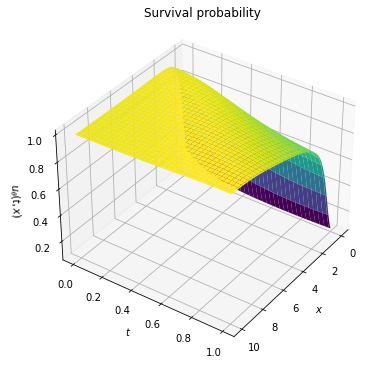

In [25]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 100
tspace = np.linspace(0.0, 1.0, N + 1)
xspace = np.linspace(0, 10, N + 1)
X, T = np.meshgrid(xspace, tspace)
Xgrid = np.vstack([X.flatten(),T.flatten()]).T

Xgrid_pred = np.array([np.append(Xgrid[x],[1.0, 2.0],axis=0) for x in range(len(Xgrid))])
upred = model_jump(tf.cast(Xgrid_pred,DTYPE))

# Reshape upred
U = 1-upred.numpy().reshape(N+1,N+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,T, U, cmap='viridis');
ax.view_init(35,35)
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel('$u_\\theta(t,x)$')
ax.set_title('Survival probability');
#plt.savefig('Burgers_Solution.pdf', bbox_inches='tight', dpi=300);

In [9]:
from plotly.offline import iplot, init_notebook_mode
import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.graph_objects as go

# Finite Difference 
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)
#init_notebook_mode()

# Neural Network 
N = 1000
tspace = np.linspace(0.0, 1.0, N + 1)
xspace = np.linspace(0, 10, N + 1)
X, T = np.meshgrid(xspace, tspace)
Xgrid = np.vstack([X.flatten(),T.flatten()]).T

Xgrid_pred = np.array([np.append(Xgrid[x],[1.0, 2.0],axis=0) for x in range(len(Xgrid))])
upred = model_jump(tf.cast(Xgrid_pred,DTYPE))

U = 1-upred.numpy().reshape(N+1 ,N+1)

data_NN = go.Surface(z = U, x = X, y= T, colorscale='Viridis', showscale = False)

layout = go.Layout(scene = dict(
                    xaxis_title='Initial Position',
                    yaxis_title='Time until maturity',
                    zaxis_title='Survival Probability'))

fig = go.Figure(data=[
    data_NN], layout=layout)

pyoff.plot(fig)
#iplot(fig)
fig.show()

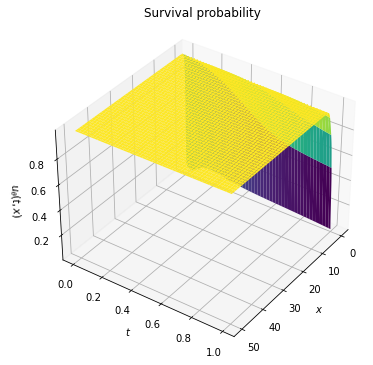

In [31]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 1000
tspace = np.linspace(0.0, 1.0, N + 1)
xspace = np.linspace(0, ub, N + 1)
X, T = np.meshgrid(xspace, tspace)
Xgrid = np.vstack([X.flatten(),T.flatten()]).T

# Determine predictions of u(t, x)
upred = model_jump(tf.cast(Xgrid,DTYPE))

# Reshape upred
U = 1-upred.numpy().reshape(N+1,N+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,T, U, cmap='viridis');
ax.view_init(35,35)
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel('$u_\\theta(t,x)$')
ax.set_title('Survival probability');
#plt.savefig('Burgers_Solution.pdf', bbox_inches='tight', dpi=300);

In [83]:
xspace_jump = np.linspace(lb, ub, 1001)
X = np.meshgrid(xspace_jump)
Xgrid_jump = np.vstack([X]).T

In [84]:
upred_jump = model_jump(tf.cast(Xgrid_jump,DTYPE))

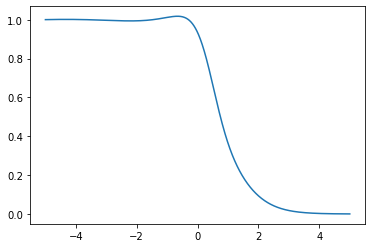

In [86]:
#upred = model_jump(tf.cast(Xgrid_jump,DTYPE))
plt.plot(xspace_jump, upred_jump)

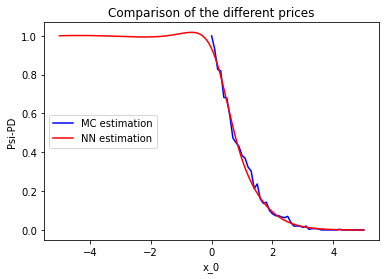

In [91]:
# Comparison with MC

x_mc = np.linspace(0.0, 5.0, 51)
mc = prob_ex_list

fig, ax = plt.subplots()
ax.plot(x_mc, mc, label='MC estimation', color='blue')
ax.plot(xspace_jump, upred_jump, label='NN estimation', color = 'red')
legend = ax.legend(loc='center left')
plt.xlabel('x_0')
plt.ylabel('Psi-PD')
plt.title('Comparison of the different prices')
plt.show()

In [1]:
#model_jump.save('NN_gen')

In [2]:
#other_model = tf.keras.models.load_model('NN_gen')

In [3]:
# u = other_model(trial)
# u

In [4]:
# fig = plt.figure(figsize=(9,6))
# ax = fig.add_subplot(111)
# ax.semilogy(range(len(np.array(hist).reshape(10001,))), np.array(hist).reshape(10001,),'k-')
# ax.set_xlabel('$n_{epoch}$')
# ax.set_ylabel('$\\phi_{n_{epoch}}$');